# Tasks
* graph generator:
    * a graph generator: that generates graphs according to the temporal adjacency(later use other features)
    * nodes are short video clips in each sliding window
    * Edges are defined as the distance of two windows.
    * Weight of edges should be between 0 and 1
    * The parameters should be tweakable: window length, step size, ...
    * each node have the information of start time, end time, and feature vector.
    * The result should be an adjacent list of nodes. also having the weight infomation. 
    * make the graph symetric
    
* Questions:
    - What would be a good way of representing the nodes.
        + Objects: learn python
        
# Steps
## Make the nodes:
short videos, feature are the histogram of 4*4000 dimensional features. 

## Make the edges:
the edges are similarities of nodes, use overlaping for time window, use the following function for feature:
$$e^{\frac{1}{\sigma^2}||x_1-x_2||_2^2}$$
include only the top K edges for each node, where K is a parameter
make it symmetric graph.

## Stats from UFC 101 dataset
| |frames|seconds|
|---|---|--|
|max length|1776|   71.04 |
|min length|29| 1.06666666667 |
|mean|186.528562849|   7.2053465966 |
|median|167|  6.48 |
|std|97.7848059441 |  3.75795650803 |

In [209]:
from pprint import pprint
from scipy import io as sio
import time
BASE_DIR = '/Users/baroc/repos/VideoActionRecognition/'

import sys
sys.path.append(BASE_DIR+'src/')

In [239]:
class Node:
    def __init__(self, start, end, fps, videoname):
        self.id = 0;
        self.start = start
        self.end = end
        self.fps = fps
        self.videoname = videoname 
        self.trajectories = []
#         self.features = dict()
#         # contains six lists of what features are avaible. This info can be used to compute the histogram
#         # use numpy.histogram or scipy.stat.histogram
#         self.features['mean_x'] = []
#         self.features['mean_y'] = []
#         self.features['traj_idx'] = []
#         self.features['hog'] = []
#         self.features['hof'] = []
#         self.features['mbh'] = []
        self.histogram = []
        self.allOverLapLabels = dict() # a dictionary of {overlapping label: [lb_str_t, lb_end_t], overlap}
        self.labels = [] # only the labels that are considered positive.
        # add groud truth
        
    def add_trajectory(self, traj): # call this when you need it
        self.trajectories.append(traj)
    def add_label(self, tlabel_info, overlap): # 
        # add to allOverLapLabels
        # tlabel_info = ['video_validation_0000051', [67.5, 75.9], 'Billiards']
        if tlabel_info[2] in self.allOverLapLabels:
            self.allOverLapLabels[tlabel_info[2]].append([tlabel_info[1],overlap])
        else:
            self.allOverLapLabels[tlabel_info[2]] = [[tlabel_info[1],overlap]]
#             self.allOverLapLabels[tlabel_info[2]].append([tlabel_info[1],overlap])
        # add to labels
        if overlap>0.5:
            self.labels.append(tlabel_info[2]) # it is possible that there are multiple same label for a node.
    def record_feature(self): 
        ###########
        # this method currently counts all existence, and don't take into account the coverage of each trajectory
        # if need the coverage info in the future, can simply modify to:
        # self.feature_cnt['mean_x'].append([traj.mean_x,traj.coverage])
        
        if len(self.features['traj_idx']) == 0:
            raise ValueError("record_features not usable. Because no features. Use add_feature in loop instead. ")
        for traj in self.trajectories:
            self.features['mean_x'].append(traj.mean_x)
            self.features['mean_y'].append(traj.mean_y)
            self.features['traj_idx'].append(traj.traj_idx)
            self.features['hog'].append(traj.hog)
            self.features['hof'].append(traj.hof)
            self.features['mbh'].append(traj.mbh)
        return
    
    def add_feature(self, mean_x, mean_y, traj, hog, hof, mbh):
        # this function computes and adds the histogram of the 16,000 features, 
        # and adds the mean_x mean_y information if necessary
        hist_hog = np.histogram(hog,4000,(0,4000))[0]
        hist_hof = np.histogram(hof,4000,(0,4000))[0]
        hist_mbh = np.histogram(mbh,4000,(0,4000))[0]
        hist_traj = np.histogram(traj,4000,(0,4000))[0]
        self.histogram = np.concatenate((hist_traj, hist_hog, hist_hof, hist_mbh))
#         self.mean_x = mean_x
#         self.mean_y = mean_y
    def set_id(self, idx):
        self.id = idx

class Trajectory:
    def __init__(self, frame_num, mean_x, mean_y, traj_idx, hog, hof, mbh, coverage):
        self.frame_num  = frame_num 
        self.mean_x  = mean_x 
        self.mean_y  = mean_y 
        self.traj_idx  = traj_idx 
        self.hog  = hog
        self.hof  = hof
        self.mbh  = mbh
        self.coverage = coverage # The portion of trajectory included in the window


def computeOverlap(window_start, window_end, label_start, label_end):
    
    if window_start < label_end and label_start < window_end:
        # overlap
        if window_start > label_start:
            l_start = window_start
            s_start = label_start
        else:
            l_start = label_start
            s_start = window_start 
        if window_end > label_end:
            l_end = window_end
            s_end = label_end
        else:
            l_end = label_end
            s_end = window_end 
        return (s_end-l_start)/(l_end - s_start)
    else:
        return 0

def generateNode(video_info, video_tLabelList,  BASE_DIR, traj_coverage_threashold = 0.5,windowSize = 150, stepSize = 100):# by frame, default value comes from the Thumos report.
    # generate nodes for a video, return a list of Node
    # before calling this function, require to find the video_info and video_tLabelList for this video. 
    video_name = video_info[0][0]
    duration_frame = video_info[8][0][0]
    fps = float(video_info[9][0])
    # read in the file and form a list of trajectory features
    with open(BASE_DIR + 'TH14_validation_features/'+video_name+'.txt','r') as f:
        # later: make the directory as a variable
        trajs = f.readlines()
    trajs = [x.split('\t')[:-1] for x in trajs]
    ####################for debug
#     trajs = trajs[:308001]
    #####################
    traj_start_idx = 0 # the index of the first trajectory of each window
    next_traj_idx = 0
    next_traj_set = False
    # form a list of window start point. 
    frame_step_list = range(0, duration_frame, stepSize)# The start of frame? 
    # Do you also need to consider the window to be full length, not truncated on the last few steps. 
    # Note that in the dataset, there is no trajectory ending on the last frame, so we don't use duration_frame+1
    window_start_frame = 0
    window_end_frame = 0
    node_list = []
    
    for i in range(len(frame_step_list) ):# For each window
        if(frame_step_list[i] + windowSize < duration_frame):
            # Both start and end are inclusive
            window_start_frame = frame_step_list[i]
            window_end_frame = frame_step_list[i] + windowSize - 1
        elif frame_step_list[i] + windowSize < duration_frame+stepSize:
            # The last window
            window_start_frame = frame_step_list[i]
            window_end_frame = duration_frame
        else:
            # Extra windows
            break
#         print window_start_frame,window_end_frame
        
        traj_start_idx = next_traj_idx 
        # next_traj_idx is used to record the start trajectory of next window, when constructing the current node
        next_traj_set = False
        # initialize node
        traj = trajs[traj_start_idx] # Current trajectory
        end_frame = int(traj[0])
        start_frame = end_frame-15+1
        new_node = Node(window_start_frame, window_end_frame, fps, video_name)
        traj_len = 15
        # feature list
        features = dict()
        features['mean_x'] = []
        features['mean_y'] = []
        features['traj'] = []
        features['hog'] = []
        features['hof'] = []
        features['mbh'] = []
        # Add trajectories, 
        while(traj_start_idx<len(trajs) and (window_start_frame<=end_frame<=window_end_frame or window_start_frame<=start_frame<=window_end_frame)):
            coverage = 1.0
            traj = trajs[traj_start_idx] # Current trajectory
            end_frame = int(traj[0])
            start_frame = end_frame-15+1
#             print "start and end"+ str(start_frame)+' , '+str(end_frame)
            if not next_traj_set and i+1 < len(frame_step_list) and end_frame >= frame_step_list[i+1]:
                next_traj_idx = traj_start_idx
                next_traj_set = True
            if(end_frame<= window_end_frame and window_start_frame<=start_frame):
                pass
            # this trajectory is totally in the window
            #     coverage = 1.0
            elif start_frame < window_start_frame and window_start_frame <= end_frame: # first few trajs
                # Only the tail of the trajectory is in the window
                coverage = float(end_frame - window_start_frame + 1)/traj_len
#                 print coverage
            elif window_end_frame >= start_frame and end_frame>window_end_frame:
                # Only head of the trajectory is in the window
                coverage = float(window_end_frame-(start_frame)+1 )/traj_len
#                 print coverage
            # add trajectory #         add_trajectory call it only when you need it!!!
#             trj_obj = Trajectory(int(traj[0]) , float(traj[1]), float(traj[2]), int(traj[3]), int(traj[4]), int(traj[5]), int(traj[6]), coverage)
#             new_node.add_trajectory(trj_obj)
                    
            # Generate the feature data, which will be used to generate 4*4000 histogram
            if coverage > traj_coverage_threashold:
                features['mean_x'].append(float(traj[1]))
                features['mean_y'].append(float(traj[2]))
                features['traj'].append(int(traj[3]))
                features['hog'].append(int(traj[4]))
                features['hof'].append(int(traj[5]))
                features['mbh'].append(int(traj[6]))
            traj_start_idx +=1
#         new_node.record_feature() # obsolete function

        # add temporal label to the list:
        window_start_time = window_start_frame/fps
        window_end_time = window_end_frame/fps
        for tlabel_info in video_tLabelList: 
            over_lap_score = computeOverlap(window_start_time, window_end_time, tlabel_info[1][0], tlabel_info[1][1])
            if over_lap_score > 0:
                new_node.add_label(tlabel_info, over_lap_score)
        # compute and add histogram
        new_node.add_feature(features['mean_x'],features['mean_y'],features['traj'],features['hog'],features['hof'],features['mbh'])
        # Add this node into a list. 
        node_list.append(new_node) 
    # return the list of nodes
    for i,node in enumerate(node_list):
        node.set_id(i)
    return node_list

Example: loading and accessing one of the feature file, uncomment to see results

In [11]:
# test_feature_file = '/Users/baroc/repos/VideoDetection/TH14_validation_features/video_validation_0000001.txt'
# with open(test_feature_file,'r') as f:
#     trajs = f.readlines()
# trajs = [x.split('\t')[:-1] for x in trajs]
# pprint(trajs[:5])
# # for x in lines:
# #     if(len(x)!=7 ):
# #         print x
# # Every line is good. 
# # [ end_frame, mean_x, mean_y, traj_id, hog, hof, mbh ]

### Load the labels
This following snippet reads and sorts the temporal labels for videos.

In [183]:
import os
import numpy as np
TLBL_DIR = BASE_DIR + 'TH14_Temporal_annotations_validation/annotation/' #'./''
filelist = os.listdir(TLBL_DIR)
tLabelList = []
for filename in filelist:
    if filename.endswith("_val.txt"): 
        with open(TLBL_DIR+filename,'r') as f:
            tLabels = f.readlines()
        tLabels = [x[:-1].split('  ') for x in tLabels]
        tLabels = [[x[0],map(float, x[1].split(' '))] for x in tLabels]
        tLabels = [x+[filename[:-8]] for x in tLabels]
        tLabelList = tLabelList+tLabels
    else:
        print('Not a txt file: '+filename)
tLabelList = sorted(tLabelList)
videonames = sorted(list(set([x[0] for x in tLabelList])))
pprint(tLabelList[:5])
pprint(tLabelList[170:175])
# print '\n'
pprint(videonames[:10])
print(len(tLabelList))

[['video_validation_0000051', [67.5, 75.9], 'Billiards'],
 ['video_validation_0000051', [85.9, 90.6], 'Billiards'],
 ['video_validation_0000051', [139.3, 148.2], 'Billiards'],
 ['video_validation_0000052', [24.3, 24.8], 'Billiards'],
 ['video_validation_0000053', [9.1, 13.8], 'Billiards']]
[['video_validation_0000162', [152.5, 155.1], 'Diving'],
 ['video_validation_0000162', [155.8, 158.5], 'CliffDiving'],
 ['video_validation_0000162', [155.8, 158.5], 'Diving'],
 ['video_validation_0000162', [163.0, 164.0], 'Ambiguous'],
 ['video_validation_0000162', [164.1, 167.1], 'CliffDiving']]
['video_validation_0000051',
 'video_validation_0000052',
 'video_validation_0000053',
 'video_validation_0000054',
 'video_validation_0000055',
 'video_validation_0000056',
 'video_validation_0000057',
 'video_validation_0000058',
 'video_validation_0000059',
 'video_validation_0000060']
3096


In the temporal action detection task, we only care about the 200 videos with temporal label. The next snippet extracts the meta data of these videos.

In [13]:
mat_file_str=BASE_DIR+"validation_set_meta/validation_set_meta/validation_set.mat"
mat = sio.loadmat(mat_file_str)
meta_array_1010 = mat['validation_videos'][0] # 1010 entries in meta_array
id_list = [int(x[-7:])-1 for x in videonames] # a list of zero based indices
meta_array_200 = meta_array_1010[id_list]
len(meta_array_200)

200

Now there are two ways to get meta data, meta_1010 is better for access by index,  meta_200 is better for looping through

#### Test Node generation
The following few lines of code **tests** the generate node function:
* First, load the meta data of videos

In [14]:
# mat_file_str="/Users/baroc/repos/VideoDetection/validation_set_meta/validation_set_meta/validation_set.mat"
# mat = sio.loadmat(mat_file_str)
# meta_array = mat['validation_videos'][0] # 1010 entries in meta_array
# NUM_VIDEOS = 1010

pprint([x for x in meta_array_200 if len(x[4])>0 ]) # These are videos with multiple actions
video_info = meta_array_1010[162]
print(video_info[0][0])
print(video_info[8][0][0])
video_tLabelList = [x for x in tLabelList if x[0]==video_info[0][0]]
pprint(video_tLabelList)
meta_array_1010[161]

[([u'video_validation_0000161'], [u'ACAPULCO MEXICO  - CLIFF DIVERS OF LA QUEBRADA.mpeg'], [u'CliffDiving'], [[22]], [[array([u'Diving'], 
      dtype='<U6')]], [[26]], [u'NO'], [[61.83]], [[1852]], [[30]], [[180]], [[320]]),
 ([u'video_validation_0000162'], [u'Celebrating 5 Years of the Red Bull Cliff Diving World Series.mpeg'], [u'CliffDiving'], [[22]], [[array([u'Diving'], 
      dtype='<U6')]], [[26]], [u'NO'], [[198.136]], [[5941]], [[30]], [[180]], [[320]]),
 ([u'video_validation_0000163'], [u'Cliff Diving in Norway - Red Bull Cliff Diving World Series 2012 Grimstad.mpeg'], [u'CliffDiving'], [[22]], [[array([u'Diving'], 
      dtype='<U6'), array([u'Rowing'], 
      dtype='<U6'), array([u'Surfing'], 
      dtype='<U7')]], [[26], [76], [88]], [u'NO'], [[233.976]], [[7016]], [[30]], [[180]], [[320]]),
 ([u'video_validation_0000164'], [u'Cliff diving qualification - Red Bull Cliff Diving World Series 2012.mpeg'], [u'CliffDiving'], [[22]], [[array([u'Diving'], 
      dtype='<U6')]], 

([u'video_validation_0000162'], [u'Celebrating 5 Years of the Red Bull Cliff Diving World Series.mpeg'], [u'CliffDiving'], [[22]], [[array([u'Diving'], 
      dtype='<U6')]], [[26]], [u'NO'], [[198.136]], [[5941]], [[30]], [[180]], [[320]])

* Invoke the `generateNode` function and time it. 150.58s

In [227]:
t = time.time()
node_list = generateNode(video_info, video_tLabelList, BASE_DIR)#, 0.5, 100, 50)
print('time elapse %.2f'% (time.time()-t) )# 19.85

time elapse 10.51


19.85 for original node implementation of feature data

13.27 for new histogram implementation + light members+coverage threashold 0

10.51 for new histogram implementation + light members+coverage threashold 0.5

* Test if the result is right for original implemenation

In [23]:
# # node_list[0].start
# # node_list[0].end

# trajs = node_list[2].trajectories
# print('All in all '+str(len(trajs))+' trajectories' )
# # [x.coverage for x in trajs[5000:5010]]
# print "end "+str(trajs[-1].frame_num) # problem
# print trajs[5000].frame_num
# print trajs[0].frame_num
# print trajs[-1].coverage
# print '\n'
# print len(node_list[2].features['hof'])
# print len(node_list[2].features['hog'])
# print len(node_list[2].features['mean_x'])
# print len(node_list[2].features['mean_y'])

In [228]:
hist = node_list[2].histogram
# print('All in all '+str(len(hist))+' histogram dimensions' )
# [x.coverage for x in trajs[5000:5010]]
print len(hist)
hist[:50]

16000


array([ 0,  0,  2,  0,  0,  0,  1,  7,  3,  1, 17,  0,  4,  8,  1,  1,  1,
        0,  0,  3,  0,  0,  0,  1,  0,  6,  0,  6,  4,  1,  9,  0,  6,  0,
        1, 32,  0,  3,  8,  1,  4,  0,  2,  0,  8, 18,  0,  2,  0,  2])

In [229]:
len(node_list)

70

* The result is right

Till now, we are able to generate nodes from feature files.

Next step would be save the node information into a file.

So later we can use it to generate edge/graph

But before that, I have a few questions on saving the data. 
* Of course, I can simply pickle it, but considering the matlab compatibility, might be better to use .mat
* How to save

In [147]:
# [[x.coverage,x.frame_num] for x in trajs[6589:]]
# len(trajs[6589:])

In [30]:
a = 2
b = 3
float(a)/b

0.6666666666666666

### Experiment with pickle
Skip this part, since this is only experimenting

In [47]:
import pickle
import cPickle
print(video_info[0][0])
t = time.time()
cPickle.dump( node_list, open( BASE_DIR + video_info[0][0]+".cp", "wb" ) )
print(time.time()-t)
t = time.time()
pickle.dump( node_list, open( BASE_DIR + video_info[0][0]+".p", "wb" ) )
print(time.time()-t)

video_validation_0000163
26.4432079792
106.701439142


Result show that when pickling one video " ", cPickle takes 26.4432079792s to save to a 251.4MB file, pickle takes 106.701439142 to save to a 224.5MB file. 

In [53]:
cPFile = open(BASE_DIR"+video_info[0][0]+".cp", 'rb')
t = time.time()
cP = cPickle.load(cPFile)
print(time.time()-t)
cPFile.close()
PFile = open("/Users/baroc/repos/VideoDetection/"+video_info[0][0]+".p", 'rb')
t = time.time()
P = cPickle.load(PFile)
print(time.time()-t)
PFile.close()

114.192363024
131.941593885


pickle load .cp 118.874449968 .p 129.021311998
cpickle load .cp 114.192363024 .p 131.941593885

Here I would like to try highest protocol

In [55]:
# protocol=pickle.HIGHEST_PROTOCOL
t = time.time()
cPickle.dump( node_list, open( "/Users/baroc/repos/VideoDetection/"+video_info[0][0]+".cp", "wb" ), protocol=pickle.HIGHEST_PROTOCOL )
print(time.time()-t)
t = time.time()
pickle.dump( node_list, open( "/Users/baroc/repos/VideoDetection/"+video_info[0][0]+".p", "wb" ), protocol=pickle.HIGHEST_PROTOCOL )
print(time.time()-t)

68.3370029926
189.640047789


with highest protocal, cpickle take 68.3370029926s to save the video to a 122.5MB file, pickle take 189.640047789s to save to a 122.5MB file

In [57]:
cPFile = open("/Users/baroc/repos/VideoDetection/"+video_info[0][0]+".cp", 'rb')
t = time.time()
cP = cPickle.load(cPFile)
print(time.time()-t)
cPFile.close()
PFile = open("/Users/baroc/repos/VideoDetection/"+video_info[0][0]+".p", 'rb')
t = time.time()
P = cPickle.load(PFile)
print(time.time()-t)
PFile.close()

124.124447107
129.871397972


Loading cP: 124.124447107 .p: 129.871397972

In [58]:
len(P[2].trajectories)

17989

### Final pickle

In [35]:
import cPickle
t = time.time()
cPickle.dump( node_list, open( BASE_DIR + video_info[0][0]+".p", "wb" ), protocol=cPickle.HIGHEST_PROTOCOL )
print(time.time()-t) # 14.753661871 0.0874960422516

0.0874960422516


In [36]:
cPFile = open(BASE_DIR+video_info[0][0]+".p", 'rb')
t = time.time()
cP = cPickle.load(cPFile)
print(time.time()-t)
cPFile.close()

0.0443379878998


14.753661871 to save, 21.7929811478 to load for original heavy implementation, about 122 mb

0.0320661067963 to save, 0.0107200145721 to load for new light implementation, only 9 mb

In [37]:
len(node_list)

70

### Computing the histogram of a node
#### Test histogram

In [52]:
hist_list = []
hist_hog = np.histogram(node_list[0].features['hog'],4000,(0,4000))[0]
hist_hof = np.histogram(node_list[0].features['hof'],4000,(0,4000))[0]
hist_mbh = np.histogram(node_list[0].features['mbh'],4000,(0,4000))[0]
hist_traj = np.histogram(node_list[0].features['traj_idx'],4000,(0,4000))[0]
# node_list[0].features['hog'] #2955, 3883, 2955, 2332, 2311, 2216,
# hist_feature = np.append(hist_hog, hist_hof)
# hist_feature = np.append(hist_feature, hist_mbh)
# hist_feature = np.append(hist_feature, hist_traj)
hist_feature = np.concatenate((hist_traj, hist_hog, hist_hof, hist_mbh))
len(hist_feature)
# type(hist_hog)
print(hist_feature[0:20])
print(hist_traj[0:20])

[ 6 20  3 14  9  2  9 17 12  6 26  0 13 15  1  0  3  2  8  0]
[ 6 20  3 14  9  2  9 17 12  6 26  0 13 15  1  0  3  2  8  0]


In [51]:
print(hist_feature[4000:4020])
print(hist_hog[0:20])

[ 2  1  8  3  3  0  0  0  0  0 17  0  4 16  0  0  0  0  0 14]
[ 2  1  8  3  3  0  0  0  0  0 17  0  4 16  0  0  0  0  0 14]


#### Final histogram
is in the code

**OMG, I should have just computed the histogram, fkr**

# Now start creating edges
This section focus on developing and experiementing with different methods to generate edges. Basically:
* based on time overlap
* based on feature

Basic idea:
* nested loop to go over each pair of node and compute if there is an edge
* present the graph using adjacent list
* make it symmetric


## Edge generator according to overlaping
Design idea:
* The generator function: 
    + mainly nested loop to go through all the nodes pairs,
    + call the compute_distance function to compute the distance, and decide whether there is an edge
    + form the adjacent list
    + call the make symetric function
    + save the graph representation
* the compute distance method - based on overlaping
* make symetric function: **Maybe make symetric on the go**

## Edge generator according to feature distance.
Design idea:
* The generator function: 
    + mainly nested loop to go through all the nodes pairs,
    + call the compute_distance function to compute the distance, and decide whether there is an edge
    + form the adjacent list
    + call the make symetric function
    + save the graph representation
* the compute distance method - based on feature similarity fuction
* make symetric function: **Maybe make symetric on the go**

### Question 
* how to represent the graph: adjacent list, but contain node? or just node ID 
* Node ID should be good


## A modification:
I would like to right a general function for generating edges, and one of the arguments would be the distance function

In [168]:
import cPickle
import time
import math
import heapq as pq
from operator import itemgetter
BASE_DIR = '/Users/baroc/repos/VideoActionRecognition/'

In [33]:
cPFile = open(BASE_DIR+video_info[0][0]+".p", 'rb')
# video_validation_0000163
t = time.time()
node_list = cPickle.load(cPFile)
print time.time() - t # 21.7929811478s 0.055123090744

0.055123090744


In [191]:
def temporal_distance(nodeA, nodeB, other):
    # Larger means more overlap: 0-1, simply percentage of the window
    if nodeA.start < nodeB.end and nodeB.start < nodeA.end:
        # overlap
        if nodeA.start < nodeB.start:
            lstart = nodeB.start
            sstart = nodeA.start
        else:
            lstart = nodeA.start
            sstart = nodeB.start
        if nodeA.end < nodeB.end:
            lend = nodeB.end
            send = nodeA.end
        else:
            lend = nodeA.end
            send = nodeB.end
        return float(send - lstart)/(nodeA.end - nodeA.start)
    else:
        return 0
    

In [64]:
# test histogram type:
a = np.array([1,2,3,4])
a1 = np.array([1,2,-1,7])
b = np.array([2,3,4,5])
print np.linalg.norm(a-a1)
print np.linalg.norm(a-b)


5.0
2.0


In [ ]:
def computeSigma(node_list):
    for node in node_list:
        feature_array.append(node.histogram)
    # compute it

In [125]:
# Speed test
import math
nodeA = node_list[9]
nodeB = node_list[8]
sigma = 3000.0
t = time.time()
l2_norm_2 = reduce(lambda x, y: x+y, [x**2 for x in nodeA.histogram - nodeB.histogram])

print(t-time.time())
print l2_norm_2
print "%.10f" % math.exp(-float(l2_norm_2)/(2*sigma)**2)
print "%.50f" % (l2_norm_2/(2*float(sigma))**2)
t = time.time()
l2_norm = np.linalg.norm(nodeA.histogram - nodeB.histogram)

print "\n"
print(t-time.time())
print l2_norm
print l2_norm/(2*sigma)
print "%.10f" % math.exp(-(l2_norm/(2*sigma))**2)
print "%.10f" % ((l2_norm/2*sigma)**2)
# type((l2_norm/2*sigma)**2)
# 1+4+9+16+25

-0.0131709575653
6410172
0.8368919295
0.17806033333333332047132557818258646875619888305664


-0.000900983810425
2531.83174796
0.421971957994
0.8368919295
14422887000000.0000000000


In [192]:
def feature_distance(nodeA, nodeB, sigma = 7):
#     l2_norm_2 = reduce(lambda x, y: x+y, [x**2 for x in nodeA.histogram - nodeB.histogram])
    l2_norm = np.linalg.norm(nodeA.histogram - nodeB.histogram)
    return math.exp(-(l2_norm/(2*sigma))**2)

def build_edge(node_list, distance_function, k=10, sigma = 7): # top K
    i = 0
    adj_list = []
    while i < len(node_list):
        j = i+1
#         print("Starting Node: %d" % i)
        while j<len(node_list):
#             print i, j
            if i == 0:
                adj_list.append([])
                
                if j == 1:
                    adj_list.append([])
#                 print adj_list
            d = distance_function(node_list[i],node_list[j], sigma)
            if distance_function == feature_distance:
                if len(adj_list[i])<k: #top K
                    pq.heappush(adj_list[i],(d,j) )
                else:
                    pq.heappushpop(adj_list[i],(d,j))
                if len(adj_list[j])<k: #top K
                    pq.heappush(adj_list[j],(d,i) )
                else:
                    pq.heappushpop(adj_list[j],(d,i))
#                 print("feature distance chosen")

            elif distance_function == temporal_distance:
#                 print("temporal distance chosen")
                
                if d > 0: # The criteria to add edge
                    adj_list[i].append((d,j))
                    adj_list[j].append((d,i))
            
            else:
                print("No such distance function")
                return
            j += 1
        i += 1
    if distance_function == feature_distance:
        print "sorting"
        i = 0
        for edges in adj_list:
            adj_list[i] = sorted(edges, key=itemgetter(1))
            i +=1
    return adj_list

In [204]:
# test
adj_list = build_edge(node_list, temporal_distance )

In [197]:
# len(adj_list)
adj_list[-10:]

[[(0.3288590604026846, 59), (0.3288590604026846, 61)],
 [(0.3288590604026846, 60), (0.3288590604026846, 62)],
 [(0.3288590604026846, 61), (0.3288590604026846, 63)],
 [(0.3288590604026846, 62), (0.3288590604026846, 64)],
 [(0.3288590604026846, 63), (0.3288590604026846, 65)],
 [(0.3288590604026846, 64), (0.3288590604026846, 66)],
 [(0.3288590604026846, 65), (0.3288590604026846, 67)],
 [(0.3288590604026846, 66), (0.3288590604026846, 68)],
 [(0.3288590604026846, 67), (0.3288590604026846, 69)],
 [(0.3288590604026846, 68)]]

In [205]:
adj_list = build_edge(node_list[:20], feature_distance, 7, 2000 )

sorting


In [206]:
pprint(adj_list[:500])

[[(0.3789437980504989, 1),
  (0.379602215825187, 9),
  (0.379129099490701, 10),
  (0.3577127460500168, 12),
  (0.3614728387719971, 13),
  (0.37631672930868665, 14),
  (0.3713141719742617, 15)],
 [(0.687644957083181, 2),
  (0.3833361494226417, 4),
  (0.41049460199729476, 5),
  (0.3896020774360183, 6),
  (0.41993892287738444, 9),
  (0.38104782949584926, 14),
  (0.38043911599845087, 18)],
 [(0.687644957083181, 1),
  (0.6979236961723831, 3),
  (0.6685457987924941, 4),
  (0.6553770893974474, 5),
  (0.6514883593738253, 9),
  (0.6463205925533528, 14),
  (0.6559263615983589, 18)],
 [(0.9134862091444825, 4),
  (0.8085278734896487, 5),
  (0.8051162315240289, 7),
  (0.7950243785143786, 10),
  (0.8441918498233447, 14),
  (0.8503959197518094, 15),
  (0.8428268411229155, 18)],
 [(0.9134862091444825, 3),
  (0.9143634626789978, 5),
  (0.8673687070111362, 6),
  (0.8336849131391247, 7),
  (0.8486149322785016, 14),
  (0.8509414110147943, 15),
  (0.9183630382818178, 18)],
 [(0.8085278734896487, 3),
  (0.9

In [ ]:
# A snippet for heap/PQ

h = []
for value in iterable:
    heappush(h, value)
return [heappop(h) for i in range(len(h))]

# Stats of videos and graph

{'Ambiguous': 89,
 'BaseballPitch': 30,
 'BasketballDunk': 303,
 'Billiards': 81,
 'CleanAndJerk': 42,
 'CliffDiving': 143,
 'CricketBowling': 178,
 'CricketShot': 181,
 'Diving': 499,
 'FrisbeeCatch': 103,
 'GolfSwing': 31,
 'HammerThrow': 199,
 'HighJump': 271,
 'JavelinThrow': 192,
 'LongJump': 163,
 'PoleVault': 120,
 'Shotput': 70,
 'SoccerPenalty': 66,
 'TennisSwing': 69,
 'ThrowDiscus': 120,
 'VolleyballSpiking': 146}


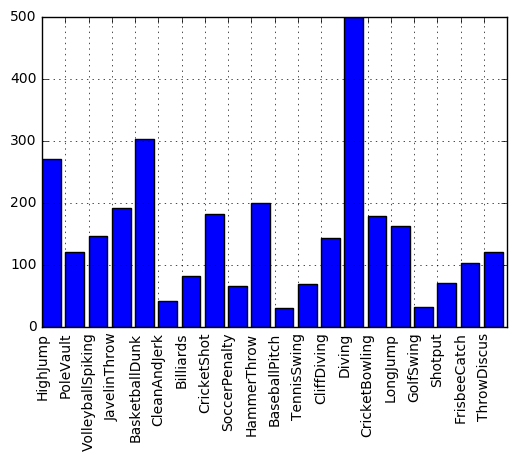

In [263]:
# The label of videos
categories = sorted(list(set([x[2] for x in tLabelList])))
count = dict([(x,0) for x in categories])
for label in tLabelList:
    count[label[2]] +=1
pprint(count)

import matplotlib.pyplot as plt
D=count
del(D['Ambiguous'])
plt.bar(range(len(D)), D.values())# ,align='center'
plt.xticks(range(len(D)), D.keys(), rotation='vertical')
plt.grid()
plt.show()

## Node distribution

In [240]:
import node_generator
cPFile = open(BASE_DIR+"validation_video_nodes.p", 'rb')
t = time.time()
all_nodes = cPickle.load(cPFile)
print time.time()-t

5.5524520874


In [241]:
len(all_nodes)

12203

In [250]:
[node.allOverLapLabels for node in all_nodes if len(node.labels)>0]

[{'Billiards': [[[67.5, 75.9], 0.5912698412698411]]},
 {'Billiards': [[[85.9, 90.6], 0.6860465116279051]]},
 {'Billiards': [[[139.3, 148.2], 0.5580524344569304]]},
 {'Billiards': [[[139.3, 148.2], 0.5407407407407384]]},
 {'Billiards': [[[9.1, 13.8], 0.6477272727272728]]},
 {'Billiards': [[[34.3, 40.1], 0.5911330049261084]]},
 {'Billiards': [[[49.7, 53.0], 0.5696202531645571]]},
 {'Billiards': [[[63.6, 68.5], 0.9096774193548383]]},
 {'Billiards': [[[74.6, 80.6], 0.509174311926606]]},
 {'Billiards': [[[74.6, 80.6], 0.559241706161135]]},
 {'Billiards': [[[96.7, 99.2], 0.5033557046979864]]},
 {'Billiards': [[[124.5, 130.0], 0.5700000000000013]]},
 {'Billiards': [[[138.4, 146.0], 0.6535087719298253]]},
 {'Billiards': [[[152.8, 156.1], 0.5030303030303003]]},
 {'Billiards': [[[163.9, 166.4], 0.5033557046979864]]},
 {'Billiards': [[[175.9, 181.0], 0.7558139534883755]]},
 {'Billiards': [[[188.8, 193.8], 0.616216216216219]]},
 {'Billiards': [[[20.5, 25.6], 0.7976190476190471]]},
 {'Billiards': [

In [251]:
[(node.start/node.fps, node.end/node.fps)  for node in all_nodes if len(node.labels)>0]

[(70.0, 74.96666666666667),
 (86.66666666666667, 91.63333333333334),
 (140.0, 144.96666666666667),
 (143.33333333333334, 148.3),
 (10.0, 14.966666666666667),
 (33.333333333333336, 38.3),
 (50.0, 54.96666666666667),
 (63.333333333333336, 68.3),
 (73.33333333333333, 78.3),
 (76.66666666666667, 81.63333333333334),
 (96.66666666666667, 101.63333333333334),
 (123.33333333333333, 128.3),
 (140.0, 144.96666666666667),
 (153.33333333333334, 158.3),
 (163.33333333333334, 168.3),
 (176.66666666666666, 181.63333333333333),
 (190.0, 194.96666666666667),
 (20.0, 24.966666666666665),
 (46.666666666666664, 51.63333333333333),
 (60.0, 64.96666666666667),
 (73.33333333333333, 78.3),
 (86.66666666666667, 91.63333333333334),
 (93.33333333333333, 98.3),
 (103.33333333333333, 108.3),
 (116.66666666666667, 121.63333333333334),
 (126.66666666666667, 131.63333333333333),
 (16.666666666666668, 21.633333333333333),
 (20.0, 24.966666666666665),
 (30.0, 34.96666666666667),
 (60.0, 64.96666666666667),
 (90.0, 94.9

In [258]:
labeled_node = [node for node in all_nodes if len(node.labels)>0]

In [259]:
labeled_node[0].labels

['Billiards']

In [255]:
len(labeled_node)

1596

{'Ambiguous': 42,
 'BaseballPitch': 27,
 'BasketballDunk': 70,
 'Billiards': 53,
 'CleanAndJerk': 26,
 'CliffDiving': 66,
 'CricketBowling': 16,
 'CricketShot': 13,
 'Diving': 210,
 'FrisbeeCatch': 33,
 'GolfSwing': 16,
 'HammerThrow': 225,
 'HighJump': 208,
 'JavelinThrow': 205,
 'LongJump': 147,
 'PoleVault': 112,
 'Shotput': 58,
 'SoccerPenalty': 43,
 'TennisSwing': 17,
 'ThrowDiscus': 57,
 'VolleyballSpiking': 18}


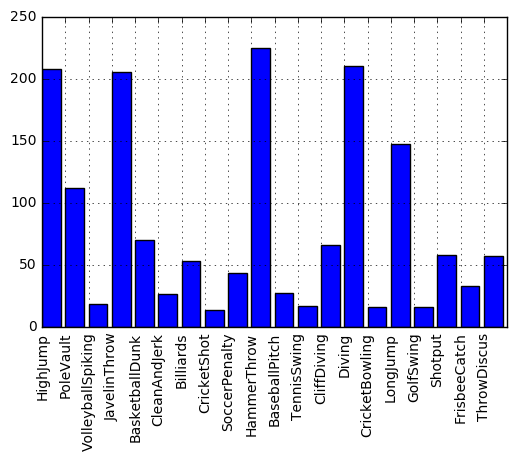

In [264]:
node_count = dict([(x,0) for x in categories])
for node in labeled_node:
    for label in node.labels:
        node_count[label] +=1
pprint(node_count)

# import matplotlib.pyplot as plt
D=node_count
del(D['Ambiguous'])
plt.bar(range(len(D)), D.values()) # , align='center'
plt.xticks(range(len(D)), D.keys(), rotation='vertical')
plt.grid()
plt.show()

# Problem with edge generation
[x] top K is not symmetric, need to redo the symetric action. 

#### After finishing all the functions this will be the start point? Maybe
The program start point: 

In [ ]:
USR_WIN = 150
USR_STEP = 100
mat_file_str="/Users/baroc/repos/VideoDetection/validation_set_meta/validation_set_meta/validation_set.mat"
mat = sio.loadmat(mat_file_str)
meta_array = mat['validation_videos'][0]
NUM_VIDEOS = 1010
for i in range(NUM_VIDEOS):
    video_info = meta_array[i]
# a structure of ([u'video_validation_0000102'], [u'Boxing Tips  - How to Punch a Boxing Bag.mpeg'], [u'BoxingPunchingBag'], [[17]], 
#    [[array([u'Punch'], dtype='<U5')]], [[71]], [u'NO'], [[152.84]], [[4582]], [[30]], [[180]], [[320]])
    video_name = video_info[0][0]
    duration_frame = video_info[8][0][0]
    fps = video_info[9][0][0]
    generateNode(video_info, USR_WIN, USR_STEP)
    
    
    
    
    
    
    

# New Task of Classification
* Mainly extract the nodes, and have a list of objects to represent the nodes.
* each node should contain as much information as possible
* 